# Deep Recurrent Q-Learning

### Resources

- https://arxiv.org/pdf/1507.06527

In [1]:

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import time
import torch
import torch.nn as nn
import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt

from collections import deque
from gymnasium.wrappers import FrameStack
from gymnasium.wrappers.frame_stack import LazyFrames
from stable_baselines3.common.atari_wrappers import (
    AtariWrapper,
    FireResetEnv,
)

gym.register_envs(ale_py)

from utils.replay import LazyFramesToNumpyWrapper, MetricTracker

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
def display_frame(frame, gray=False):
    if gray:
        plt.imshow(frame, cmap='gray')
    else:
        plt.imshow(frame)
    plt.axis('off')
    plt.show()

In [42]:
def display_multiple_frames(frames):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(frames[i], cmap='gray')
        ax.axis('off')
    plt.show()

In [47]:
class FlickeringAtari(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.env = env

    def observation(self, observation, prob=0.5):
        if np.random.rand() < prob:
            observation = np.zeros_like(observation)
        return observation

In [48]:
def make_env(game, render='rgb_array'):
    env = gym.make(game, render_mode=render)
    env = AtariWrapper(env, terminal_on_life_loss=False)
    env = LazyFramesToNumpyWrapper(env)
    env = FlickeringAtari(env)
    if "FIRE" in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    return env

In [49]:
env_test = make_env('FrostbiteNoFrameskip-v4')

(84, 84, 1)


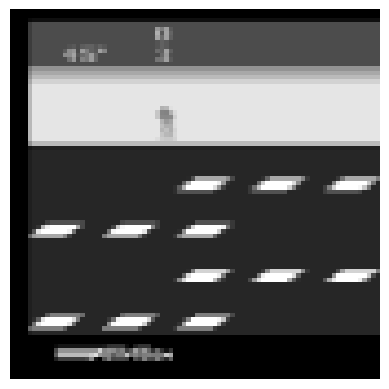

In [63]:
observation, _ = env_test.reset()
print(observation.shape)
display_frame(observation, gray=True)

In [117]:
from copy import deepcopy

class Episode:
    
    def __init__(
        self
    ):
        self.obs = []
        self.actions = []
        self.rewards = []
        self.obs_prime = []
        self.dones = []
        
    def add_step(
        self,
        observation,
        action, 
        reward, 
        observation_prime, 
        terminated
    ):
        self.obs.append(observation)
        self.actions.append(action)
        self.rewards.append(reward)
        self.obs_prime.append(observation_prime)
        self.dones.append(terminated)
        
    def __getitem__(self, index):
        if isinstance(index, slice):
            ep = Episode()
            ep.obs = self.obs[index]
            ep.actions = self.actions[index]
            ep.rewards = self.rewards[index]
            ep.obs_prime = self.obs_prime[index]
            ep.dones = self.dones[index]
            return ep
        elif isinstance(index, tuple):
            arg = index[0]
            pos = index[1]
            if arg == 0: 
                return self.obs[pos]
            elif arg == 1:
                return self.actions[pos]
            elif arg == 2:
                return self.rewards[pos]
            elif arg == 3:
                return self.obs_prime[pos]
            elif arg == 4:
                return self.dones[pos]
         
        return (
            self.obs[index],
            self.actions[index],
            self.rewards[index],
            self.obs_prime[index],
            self.dones[index]
        )
    
    def pad(self, stop):
        new_ep = Episode()
        new_ep.obs = deepcopy(self.obs)
        new_ep.actions = deepcopy(self.actions)
        new_ep.rewards = deepcopy(self.rewards)
        new_ep.obs_prime = deepcopy(self.obs_prime)
        new_ep.dones = deepcopy(self.dones)
        def pad_field(arr, stop, zeros):
            for i in range(stop):
                if i >= len(arr):
                    arr.append(zeros)
        
        pad_field(new_ep.obs, stop, zeros=np.zeros_like(self.obs[0]))
        pad_field(new_ep.actions, stop, zeros=np.int64(0))
        pad_field(new_ep.rewards, stop, zeros=np.float32(0.0))
        pad_field(new_ep.obs_prime, stop, zeros=np.zeros_like(self.obs_prime[0]))
        pad_field(new_ep.dones, stop, zeros=True)
        
        return new_ep
    
    def __len__(self):
        return len(self.obs)
    
    def __repr__(self):
        return f'Episode of Length {len(self)}'

In [118]:
observation, _ = env_test.reset()
done = False
ep = Episode()
while not done:
    action = env_test.action_space.sample()
    observation_prime, reward, terminated, truncated, _ = env_test.step(action) 
    ep.add_step(
        observation.squeeze(),
        action, 
        reward, 
        observation_prime.squeeze(),
        terminated or truncated
    )
    
    done = terminated or truncated
    observation = observation_prime
ep

Episode of Length 316

In [119]:
padded_ep = ep.pad(500)
ep, padded_ep

(Episode of Length 316, Episode of Length 500)

In [127]:
import random

class ReplayBufferDRQN:
    
    def __init__(self, capacity, device='cuda'):
        self._buffer = deque(maxlen=capacity)
        self.device = device
    
    def store(self, episode):
        self._buffer.append(episode)
    
    def sample(self, batch_size):
        batch = random.sample(self._buffer, batch_size)
        max_len = len(max(batch, key=len))
        padded_batch = [ep.pad(max_len) for ep in batch]
        
        return (
            self.extract_item(padded_batch, 0, (batch_size, max_len, 1, 84, 84), dtype=torch.float32),
            self.extract_item(padded_batch, 1, (batch_size, max_len, 1), dtype=torch.int64),
            self.extract_item(padded_batch, 2, (batch_size, max_len, 1), dtype=torch.float32),
            self.extract_item(padded_batch, 3, (batch_size, max_len, 1, 84, 84), dtype=torch.float32),
            self.extract_item(padded_batch, 4, (batch_size, max_len, 1), dtype=torch.bool)
        )

    def extract_item(self, batch, arg, shape, dtype):
        batched_values = np.array([val[arg, :] for val in batch]).reshape(shape)
        batched_values = torch.as_tensor(batched_values, dtype=dtype, device=self.device)
        return batched_values

    def __getitem__(self, index):
        return self._buffer[index]
        
    def __len__(self):
        return len(self._buffer)

In [128]:
buffer = ReplayBufferDRQN(10)

observation, _ = env_test.reset()
for _ in range(10):    
    observation, _ = env_test.reset()
    done = False
    ep = Episode()
    while not done:
        action = env_test.action_space.sample()
        observation_prime, reward, terminated, truncated, _ = env_test.step(action) 
        ep.add_step(
            observation.squeeze(),
            action, 
            reward, 
            observation_prime.squeeze(),
            terminated or truncated
        )
        
        done = terminated or truncated
        observation = observation_prime
        
    buffer.store(ep)

In [130]:
test_obs, test_act, test_rew, test_prime, test_dones = buffer.sample(2)

In [131]:
test_obs.shape, test_act.shape, test_rew.shape, test_prime.shape, test_dones.shape

(torch.Size([2, 337, 1, 84, 84]),
 torch.Size([2, 337, 1]),
 torch.Size([2, 337, 1]),
 torch.Size([2, 337, 1, 84, 84]),
 torch.Size([2, 337, 1]))

In [133]:
def load_buffer(preload, capacity, game, prob=0.5):
    env = make_env(game)
    buffer = ReplayBufferDRQN(capacity)

    observation, _ = env.reset()
    for _ in range(preload):    
        observation, _ = env_test.reset()
        done = False
        ep = Episode()
        while not done:
            action = env_test.action_space.sample()
            observation_prime, reward, terminated, truncated, _ = env_test.step(action)
        
            ep.add_step(
                observation.squeeze(),
                action, 
                reward, 
                observation_prime.squeeze(),
            )
            
            done = terminated or truncated
            observation = observation_prime
        
        buffer.store(ep)
            
    return buffer, env

In [134]:
class DRQN(nn.Module):
    
    def __init__(
        self, 
        env,
        in_channels=1, 
        hidden_filters=list([32, 64, 64]),
        hidden_size=512,
        start_epsilon = 0.99,
        max_decay = 0.1,
        decay_steps = 1000,  
        *args, 
        **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.env = env
        self.start_epsilon = start_epsilon
        self.epsilon = start_epsilon
        self.max_decay = max_decay
        self.decay_steps = decay_steps
        self.num_actions = env.action_space.n
        
        self.layers_cnn = nn.Sequential(
            nn.Conv2d(in_channels, hidden_filters[0], kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(hidden_filters[0], hidden_filters[1], kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(hidden_filters[1], hidden_filters[2], kernel_size=3, stride=1),
            nn.ReLU(),
        )
        

        self.lstm = nn.LSTM(hidden_filters[-1] * 7 * 7, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, self.num_actions)
        
        self.apply(self._init)
    
    def forward(self, x):
        B, T, C, H, W = x.shape
        x_view = x.view(-1, C, H, W)
        x_view = self.layers_cnn(x_view / 255.0)
        
        x_view = x_view.reshape(B, T, -1)
        hidden_states, _ = self.lstm(x_view)
        output = self.linear(hidden_states)
        
        return output
    
       
    def _init(self, m):
      if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
          nn.init.zeros_(m.bias)
              
    def epsilon_greedy(self, state, dim=-1):
        rng = np.random.random()

        if rng < self.epsilon:
            action = self.env.action_space.sample()
            action = torch.tensor(action)
        else:
            with torch.no_grad():
                q_values = self(state)
            
            action = torch.argmax(q_values.squeeze(), dim=dim)

        return action

    def epsilon_decay(self, step):
        self.epsilon = self.max_decay + (self.start_epsilon - self.max_decay) * max(0, (self.decay_steps - step) / self.decay_steps)
        


In [108]:
net = DRQN(env_test, start_epsilon=0.0).to(device)
rand = torch.randn((1, 1, 1, 84, 84)).to(device)
net(rand).shape

torch.Size([1, 1, 18])

In [135]:
class MetricTrackerDRQN:
    def __init__(self, window_size=100):
        self.window_size = window_size
        self.rewards = deque(maxlen=window_size)
        
    def add_episode_reward(self, reward):
        self.current_episode_reward += reward
        
    @property
    def avg_reward(self):
        return np.mean(self.rewards) if self.rewards else 0
        

In [ ]:
def train(
    env, 
    name, 
    q_network, 
    target_network, 
    timesteps, 
    replay, 
    train_freq, 
    batch_size, 
    gamma, 
    decay_start,
    C,
    save_step=850000,
):
    loss_func = nn.MSELoss()
    start_time = time.time()
    episode_count = 0
    best_avg_reward = -float('inf')
    metrics = MetricTracker()
    
    optimizer = torch.optim.RMSprop(q_network.params(), lr=2.5e-4, momentum=0.95, alpha=0.95, eps=0.01)
    
    for step in range(1, timesteps+1):
        
        # sample full episode 
        obs, _ = env.reset()
        done = False
        episode = Episode()
        while not done:
            batched_obs = obs.reshape(1, 1, 1, 84, 84)
            action = q_network.epsilon_greedy(torch.as_tensor(batched_obs, dtype=torch.float32, device=device)).cpu().item()
            obs_prime, reward, terminated, truncated, _ = env.step(action)
            
            episode.add_step(
                obs, 
                action,
                reward, 
                obs_prime,
                terminated or truncated
            )
            
            obs = obs_prime
            done = terminated or truncated
        
        replay.store(episode)
        
        if step % train_freq == 0:
            pass # do training here
        
        if step > decay_start: 
            q_network.epsilon_decay(step)
            target_network.epsilon_decay(step)
        
        elapsed_time = time.time() - start_time
        steps_per_sec = step / elapsed_time
        metrics.end_episode()
        episode_count += 1
        
        if metrics.avg_reward > best_avg_reward and step > save_step:
            best_avg_reward = metrics.avg_reward
            torch.save({
                'step': step,
                'model_state_dict': q_network.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'avg_reward': metrics.avg_reward,
            }, f"models/{name}_dqn_best_{step}.pth")
            
        print(f"\rStep: {step:,}/{timesteps:,} | "
                f"Episodes: {episode_count} | "
                f"Avg Reward: {metrics.avg_reward:.1f} | "
                f"Epsilon: {q_network.epsilon:.3f} | "
                f"Steps/sec: {steps_per_sec:.1f}", end="\r")
